In [11]:
import jax
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
from jax import Array
import jax.numpy as jnp
import equinox as eqx


import femsolver
from femsolver.utils import auto_vmap, vmap
from femsolver import Mesh, Operator, element


import matplotlib.pyplot as plt
import cmcrameri.cm as cmc


In [12]:
# --- Mesh generation ---
def generate_unit_square_mesh_tri(nx, ny):
    x = jnp.linspace(0, 1, nx + 1)
    y = jnp.linspace(0, 1, ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements.append([n0, n1, n3])
            elements.append([n0, n3, n2])
    return coords, jnp.array(elements)

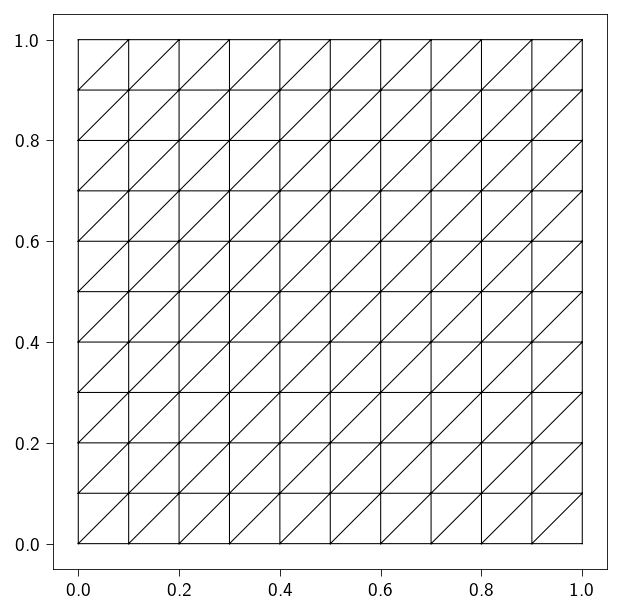

In [64]:
mesh = Mesh.unit_square(10, 10)

n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

plt.style.use(femsolver.plotting.STYLE_PATH)
plt.triplot(*mesh.coords.T, mesh.elements, color="k", lw=0.5)
plt.gca().set_aspect("equal")

## Defining the constitutive behavior of the material

We define a function to compute the linear elastic energy density based on the displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x) 
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and 

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$


To ease the handling of the material paramters and later on ease the integration of the material parameters for computing energy density, we define a class `Material` that can be used to define the material parameters.

In [85]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Shear modulus
    lmbda: float  # First Lamé parameter


mat = Material(mu=0.5, lmbda=1.0)


Now, we define bunch of functions to compute the strain, stress, and strain energy.

In [93]:
@auto_vmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.T)

@auto_vmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I

@auto_vmap(grad_u=2, mu=0, lmbda=0)
def strain_energy(grad_u: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(eps * sig)


## Defining Operator


In `femsolver`, we define a operator class that is capable of performing various mathematical operations on the mesh. For example,
-  Integrate a field (form of nodal values) over the mesh
   $$ \int_{\Omega} f(\mathbf{x}) d\Omega $$
-  Compute the gradient of a field
   $$ \nabla f(\mathbf{x}) $$
- Compute the field values at the quadrature points
   $$ f(\mathbf{x}) $$


To perform these operations, the operator class requires the following information:
- The mesh (nodes and elements)
- The element type (e.g. triangle, quadrilateral, etc. with quadrature points)

Below, we define such an operator that can perform the above operations over `triangular` elements.


In [94]:
tri = element.Tri3()
op = Operator(mesh, tri)


@op.integrate
def total_strain_energy(u: Array, u_grad: Array, *_) -> Array:
    """Compute the total energy of the system."""
    return strain_energy(u_grad, mat.mu, mat.lmbda)

Now we can define a function that takes the nodal displacements and uses the above defined decorated `total_strain_energy` to compute the total energy.

In [95]:
@jax.jit
def total_energy(u_flat):
    u = u_flat.reshape(-1, n_dofs_per_node)
    return total_strain_energy(u)


## Solve system

We arrange the system such that the unknown vector $u$ is flattened. Once we find the solution, we will reshape it back to the original shape.

1. create the unknown vector $u$ with the shape of the number of nodes times the number of degrees of freedom per node
2. create the system matrix $K$ and the right-hand side vector $f$
3. solve the system $K u = f$ for $u$

::: {.callout-note}
We apply the boundary condition using matrix lifting
:::


In [96]:

# creating functions to compute the gradient and 
# Hessian of the total energy using jax
gradient = jax.grad(total_energy)
hessian = jax.jacfwd(jax.grad(total_energy))

# compute the hessian which is the stiffness matrix 
# and the gradient which is the internal force vector 
u = jnp.zeros((n_dofs))

K = hessian(u)
f_int = gradient(u)

# --- Apply Dirichlet BCs ---
left_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 0.0))[0]
right_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 1.0))[0]
fixed_dofs = jnp.concatenate(
    [
        2 * left_nodes,
        2 * left_nodes + 1,
        2 * right_nodes,
    ]
)
prescribed_values = jnp.zeros(n_dofs).at[2 * right_nodes].set(0.3)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

# --- Solve for the displacement ---
f_ext = -f_int - K @ prescribed_values
f_reduced = f_ext[free_dofs]
K_reduced = K[jnp.ix_(free_dofs, free_dofs)]
u_free = jnp.linalg.solve(K_reduced, f_reduced)
u_full = prescribed_values.at[free_dofs].set(u_free)

## Post-processing

Now we prepare some functions to compute the stress and to plot the deformed shape with the von-mises stress.

In [97]:
@auto_vmap(stress=2)
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)

u_solution = u_full.reshape(-1, n_dofs_per_node)
# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)
stress_vm = von_mises_stress(stresses)

In [98]:
from femsolver.plotting import STYLE_PATH
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_displacement_and_stress(u, mesh, stress, scale=1.0):
    displaced = mesh.coords + scale * u
    tri_elements = mesh.elements
    
    plt.style.use(STYLE_PATH)
    fig =plt.figure(figsize=(5, 4))
    ax = plt.axes()
    cb =ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    ax.set_title("Von Mises Stress on Deformed Mesh")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax)
    plt.show()

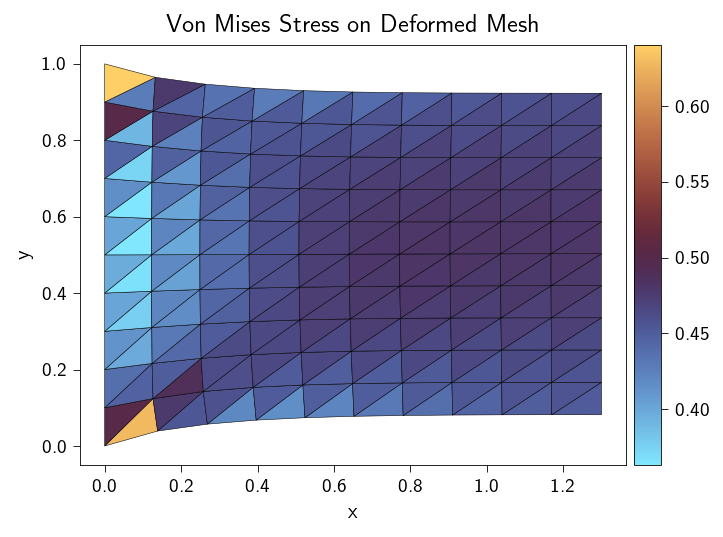

In [99]:
# --- Plot the displacement and stress ---
plot_displacement_and_stress(u_solution, mesh, stress_vm.flatten())